#### Fase 2:  Identificación de atributos en común entre los miembros de las comunidades.
**Grupo 14**
- Edna Julieth Mora Albarracin
- Elvin Rodrigo Mendez Gamba
- Juan Jose Miguel Ovalle Villamil

#### Librerias y Configuracion

In [224]:
import os
from pathlib import Path

from community import community_louvain
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

import sweetviz as sv

DATA_PATH = Path("../data/")

In [2]:
os.listdir(DATA_PATH)

['Arcos.xlsx', 'Nodos.xlsx']

#### Lectura de datos y Carga de la red

In [3]:
# Se cargan los datos de los nodos
nodos = pd.read_excel(DATA_PATH / "Nodos.xlsx")
print(f"Filas: {nodos.shape[0]:,}, Columnas: {nodos.shape[1]}")
nodos.head()

Filas: 2,211, Columnas: 33


Id                       Headquarters Location  \
0         Tencent                  Shenzhen, Guangdong, China   
1  Warburg Pincus           New York, New York, United States   
2         Twitter    San Francisco, California, United States   
3         Ubisoft  Montreuil-sous-bois, Ile-de-France, France   
4          WeWork           New York, New York, United States   

  Operating Status Company Type  Number of Investments  \
0           Active   For Profit                  693.0   
1           Active          NaN                  433.0   
2           Active   For Profit                   10.0   
3           Active   For Profit                    9.0   
4           Active   For Profit                    9.0   

   Number of Lead Investments  Number of Diversity Investments  \
0                       375.0                             15.0   
1                       286.0                             22.0   
2                         2.0                              1.0   
3                         NaN                              NaN   
4                         6.0                              4.0   

   Number of Exits  Number of Lead Investors  Number of Investors  ...  \
0            125.0                       1.0                  4.0  ...   
1            131.0                       NaN                  NaN  ...   
2              3.0                       9.0                 37.0  ...   
3              1.0                       1.0                  4.0  ...   
4              2.0                      11.0                 24.0  ...   

  Total Funding Amount Total Funding Amount Currency  \
0         1.257677e+10                           USD   
1         3.802820e+07                           USD   
2         4.430192e+09                           USD   
3         7.706506e+08                           USD   
4         2.159578e+10                           USD   

   Total Funding Amount Currency (in USD) Number of Events  \
0                            1.257677e+10             22.0   
1                            3.802820e+07              NaN   
2                            4.430192e+09             77.0   
3                            7.706506e+08             16.0   
4                            2.159578e+10            120.0   

  SEMrush - Monthly Visits  SEMrush - Average Visits (6 months)  \
0                4,085,844                            3,553,184   
1                   34.635                            34,033.67   
2            6,026,399,205                     3,104,998,131.33   
3               32,820,567                        27,881,933.83   
4                2,646,155                         2,483,475.83   

  SEMrush - Visit Duration  Aberdeen - IT Spend Aberdeen - IT Spend Currency  \
0                    600.0                  NaN                          NaN   
1                    392.0              53801.0                          USD   
2                    942.0                  NaN                          NaN   
3                    392.0                  NaN                          NaN   
4                    280.0             343977.0                          USD   

  Aberdeen - IT Spend Currency (in USD)  
0                                   NaN  
1                               53801.0  
2                                   NaN  
3                                   NaN  
4                              343977.0  

[5 rows x 33 columns]

In [4]:
# Se cargan los datos de los arcos
arcos = pd.read_excel(DATA_PATH / "Arcos.xlsx")
print(f"Filas: {arcos.shape[0]:,}, Columnas: {arcos.shape[1]}")
arcos.head()

Filas: 4,187, Columnas: 2


Source     Target
0    01 Advisors   Electric
1    01 Advisors     Origin
2  17Capital LLP  NewSpring
3            1kx    Arweave
4            1kx    Rarible

In [23]:
# Se crea la red apartir de los datos de los arcos
G = nx.from_pandas_edgelist(
    df=arcos,
    source="Source",
    target="Target",
    create_using=nx.DiGraph() # Se asegura que la red sea dirigida
)

# Se inspecciona el numero de nodos y arcos
print(f"Nodos: {G.number_of_nodes():,}")
print(f"Arcos: {G.number_of_edges():,}")

Nodos: 2,165
Arcos: 4,187


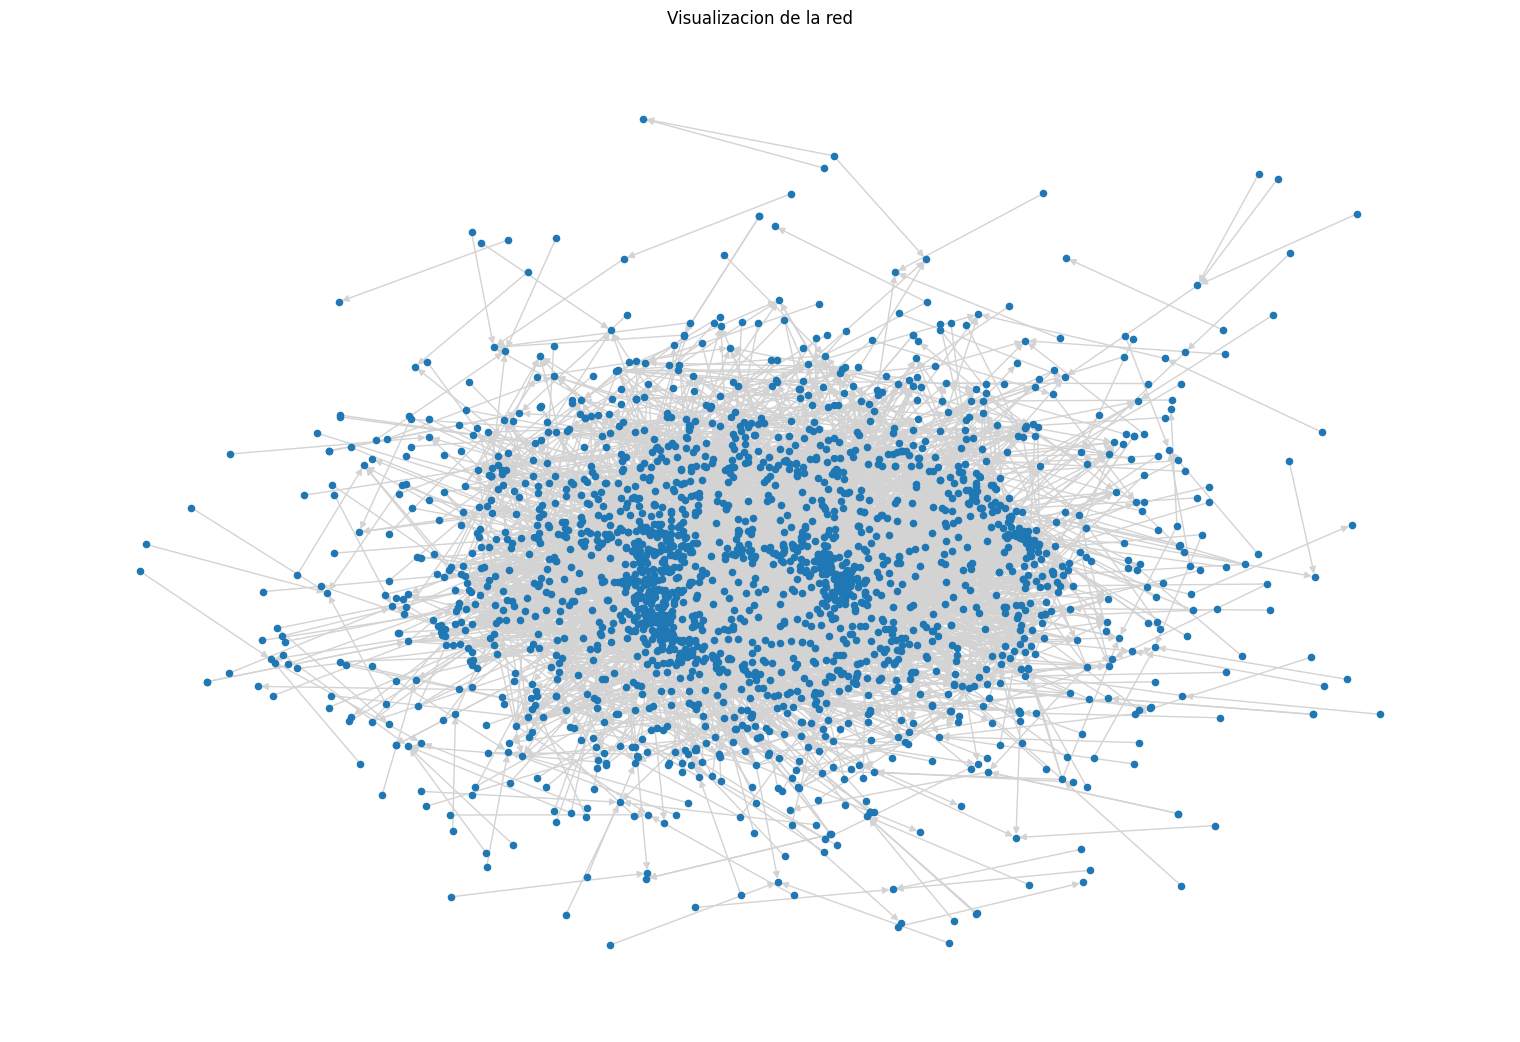

In [25]:
plt.figure(figsize=(15, 10))
nx.draw_kamada_kawai(
    G=G,
    node_size=20,
    edge_color='lightgray'
)
plt.title("Visualizacion de la red")
plt.show()

### 1. Identificacion de Comunidades

#### 1.1 Algoritmo de Louvain
Este algoritmo es particularmente útil en este contexto debido a su capacidad para identificar comunidades de manera eficiente en redes grandes, lo cual es común en redes de organizaciones. La razón principal para elegir el método de Louvain radica en su enfoque en optimizar la modularidad, lo que permite descubrir agrupaciones naturales dentro de la red basadas en la densidad de conexiones. Esto es crucial para una organización que busca financiamiento, ya que permite identificar grupos de organizaciones con intereses o misiones similares, facilitando la identificación de posibles colaboradores o financiadores que comparten objetivos alineados con los de la organización en búsqueda de recursos.


In [49]:
# Se convierte a no dirigida
G_undirected = G.to_undirected()

# Algoritmo de Louvain
partition_louvain = community_louvain.best_partition(graph=G_undirected, random_state=1399)

In [50]:
# Se crea un dataframe con la asignacion de comunidades
comunidades = pd.DataFrame(
    data=partition_louvain.items(),
    columns=["Nodo", "Comunidad"]
)
comunidades.head().T

0         1       2              3          4
Nodo       01 Advisors  Electric  Origin  17Capital LLP  NewSpring
Comunidad            7         7       7              1          1

In [51]:
# Numero de comunidades
print(f"Numero de comunidades: {comunidades['Comunidad'].nunique()}")

Numero de comunidades: 35


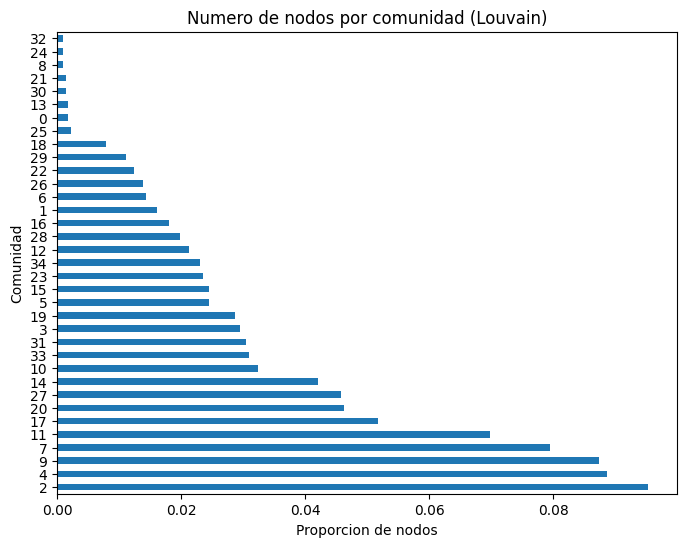

In [96]:
comunidades["Comunidad"].value_counts(True).plot(kind="barh", figsize=(8, 6), title="Numero de nodos por comunidad (Louvain)")
plt.ylabel("Comunidad")
plt.xlabel('Proporcion de nodos')
plt.show()

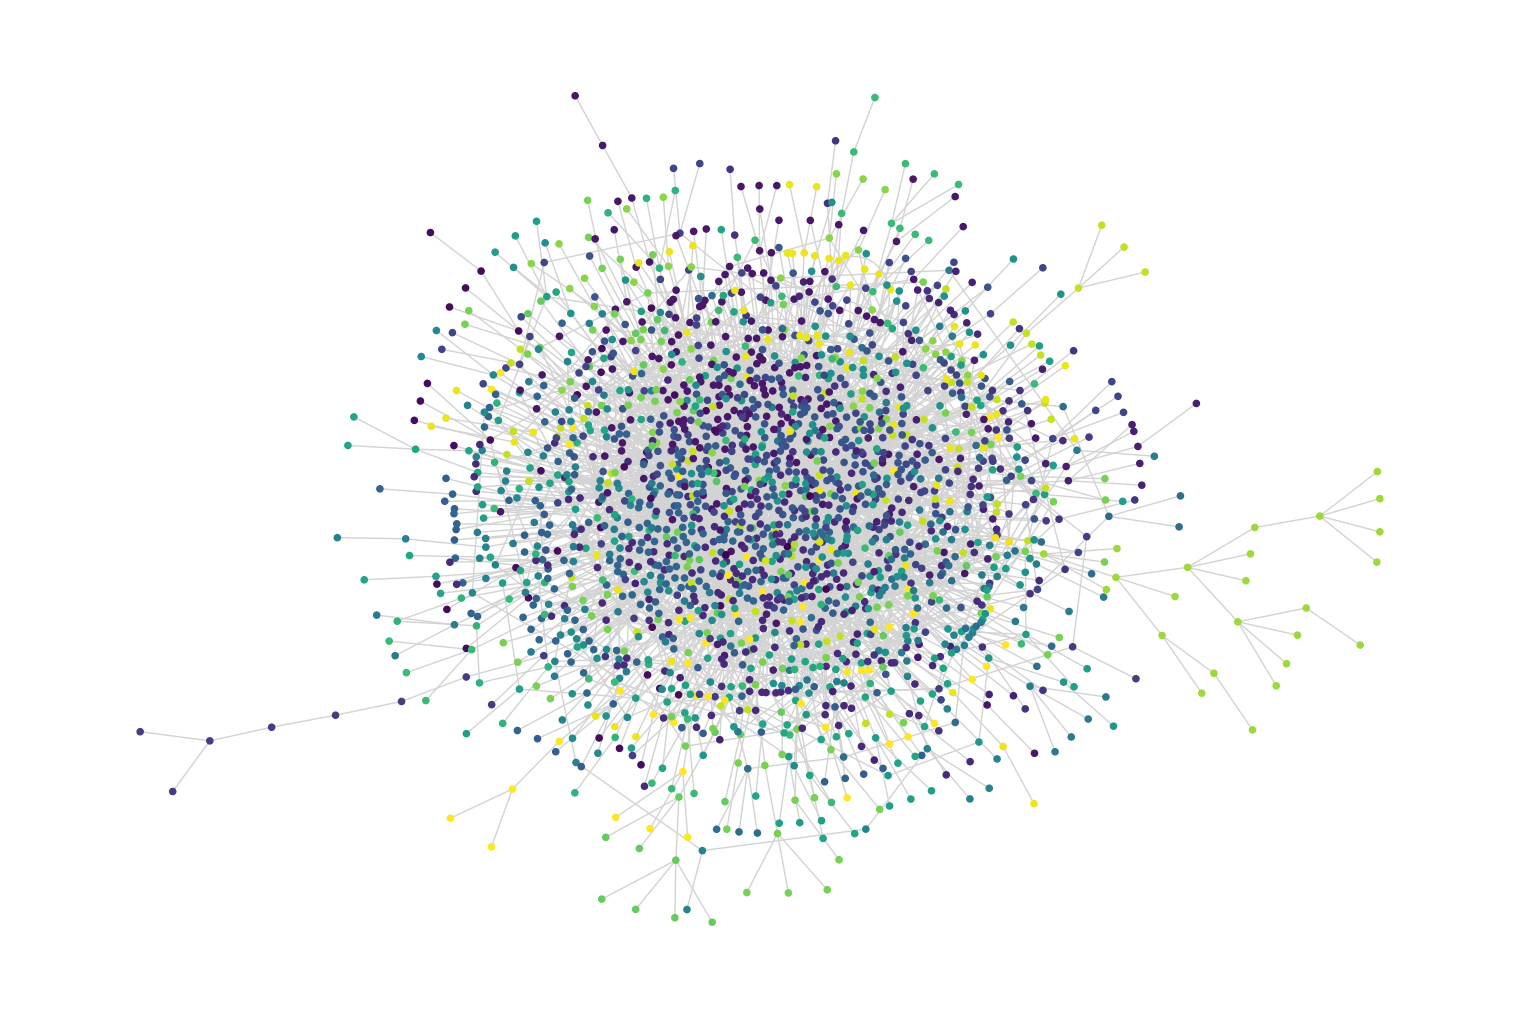

In [54]:
plt.figure(figsize=(15, 10))
pos = nx.kamada_kawai_layout(G=G_undirected)
nx.draw(
    G=G_undirected,
    pos=pos,
    node_size=20,
    node_color=list(partition_louvain.values()),
    edge_color='lightgray'
)
plt.title("Comunidades detectadas por Louvain")
plt.show()

#### 1.2 Label Propagation
Este algoritmo es relevante para detectar comunidades en redes de organizaciones e inversores debido a su simplicidad y eficacia, especialmente en redes con un gran overlap entre nodos. Este método asigna etiquetas a los nodos basándose en las etiquetas más frecuentes entre sus vecinos, lo que facilita la identificación de comunidades basadas en relaciones directas e intereses compartidos. Esto es particularmente útil para una organización que busca financiamiento, ya que puede revelar inversores potenciales que ya están conectados con organizaciones similares, indicando una predisposición a invertir en ciertos tipos de empresas o sectores.

In [88]:
# Algoritmo LPA
lpa = list(nx.algorithms.community.label_propagation_communities(G=G_undirected))
lpa_fix = {nodo: idx for idx, comunidad in enumerate(lpa) for nodo in comunidad}

In [89]:
# Se crea un dataframe con la asignacion de comunidades
comunidades_lpa = pd.DataFrame(
    data=lpa_fix.items(),
    columns=["Nodo", "Comunidad"]
)
comunidades_lpa.head().T

0       1       2        3          4
Nodo       01 Advisors  Origin  Andela  Twitter  Darktrace
Comunidad            0       0       1        1          1

In [90]:
# Numero de comunidades
print(f"Numero de comunidades detectadas: {comunidades_lpa['Comunidad'].nunique()}")

Numero de comunidades detectadas: 266


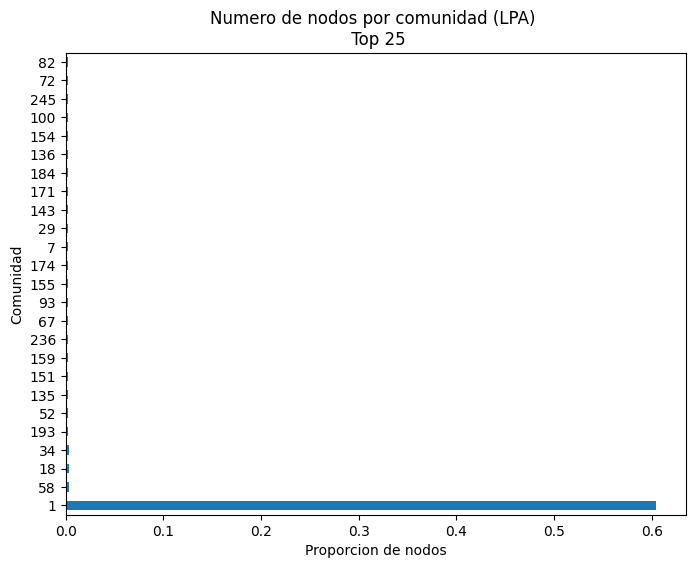

In [95]:
comunidades_lpa['Comunidad'].value_counts(True)\
    .nlargest(25)\
    .plot(kind='barh', figsize=(8, 6), title='Numero de nodos por comunidad (LPA) \n Top 25')
plt.ylabel('Comunidad')
plt.xlabel('Proporcion de nodos')
plt.show()

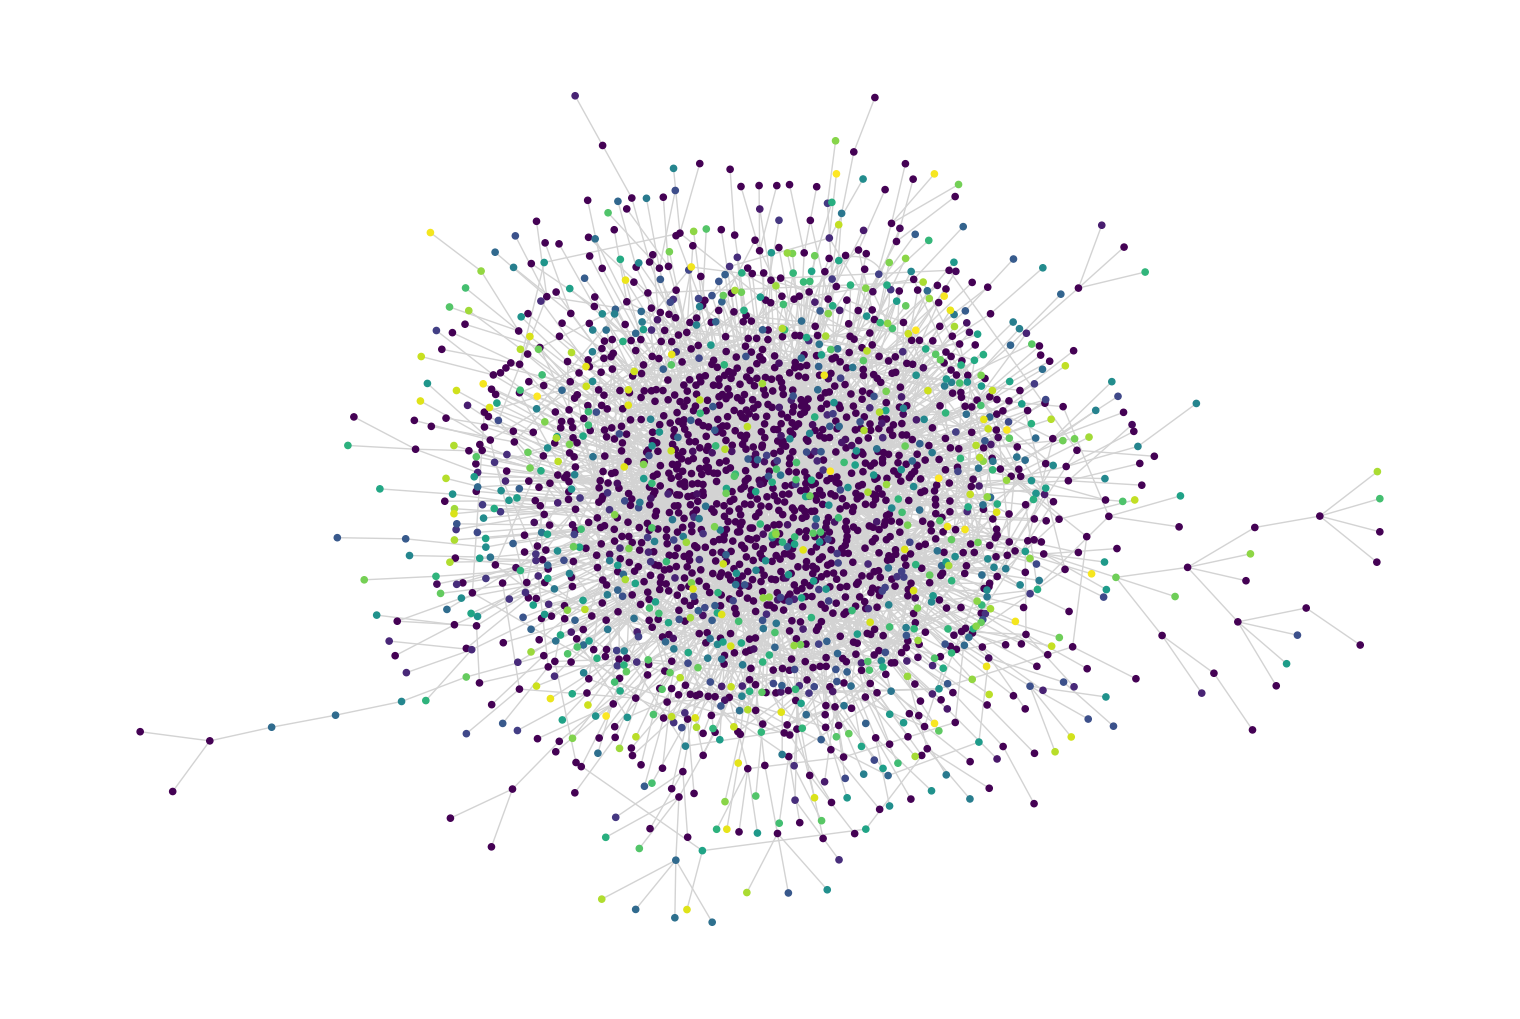

In [78]:
plt.figure(figsize=(15, 10))
pos = nx.kamada_kawai_layout(G=G_undirected)
nx.draw(
    G=G_undirected,
    pos=pos,
    node_size=20,
    node_color=list(lpa_fix.values()),
    edge_color='lightgray'
)
plt.title("Comunidades detectadas por LPA")
plt.show()

#### 1.3 Metodo de Overlapping - Cliques Percolation
Este algoritmo es significativo en el contexto de análisis de redes de financiamiento debido a su enfoque único en identificar comunidades como uniones de cliques (grupos de nodos que están todos conectados entre sí). Este enfoque es particularmente adecuado para redes con alta superposición de nodos, ya que permite descubrir grupos densamente conectados de organizaciones e inversores. Para una organización en busca de financiamiento, este método puede destacar clusters de inversores con intereses muy específicos y conexiones estrechas, lo que podría indicar una mayor probabilidad de inversión en proyectos que se alineen estrechamente con las preferencias o el enfoque de dichos grupos.

In [146]:
# Cliques Percolation
K=3
cp = list(nx.community.k_clique_communities(G=G_undirected, k=K))
cp_fix = {node: -1 for node in G_undirected.nodes()} # Algunos nodos no estan en ninguna comunidad
cp_fix.update({nodo: idx for idx, comunidad in enumerate(cp) for nodo in comunidad})

In [147]:
# Se crea un dataframe con la asignacion de comunidades
comunidades_cp = pd.DataFrame(
    data=cp_fix.items(),
    columns=["Nodo", "Comunidad"]
)
comunidades_cp.head().T

0         1       2              3          4
Nodo       01 Advisors  Electric  Origin  17Capital LLP  NewSpring
Comunidad           -1        -1      -1             -1         -1

In [148]:
# Numero de comunidades
print(f"Numero de comunidades detectadas: {comunidades_cp['Comunidad'].nunique() - 1}")

Numero de comunidades detectadas: 46


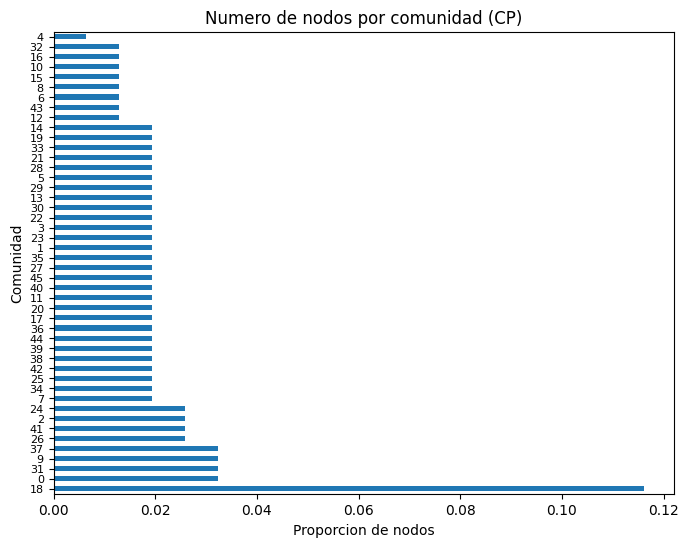

In [150]:
comunidades_cp['Comunidad'][comunidades_cp["Comunidad"] != -1].value_counts(True)\
    .plot(kind='barh', figsize=(8, 6), title='Numero de nodos por comunidad (CP)')
plt.ylabel('Comunidad')
plt.xlabel('Proporcion de nodos')
plt.yticks(size=8)
plt.show()

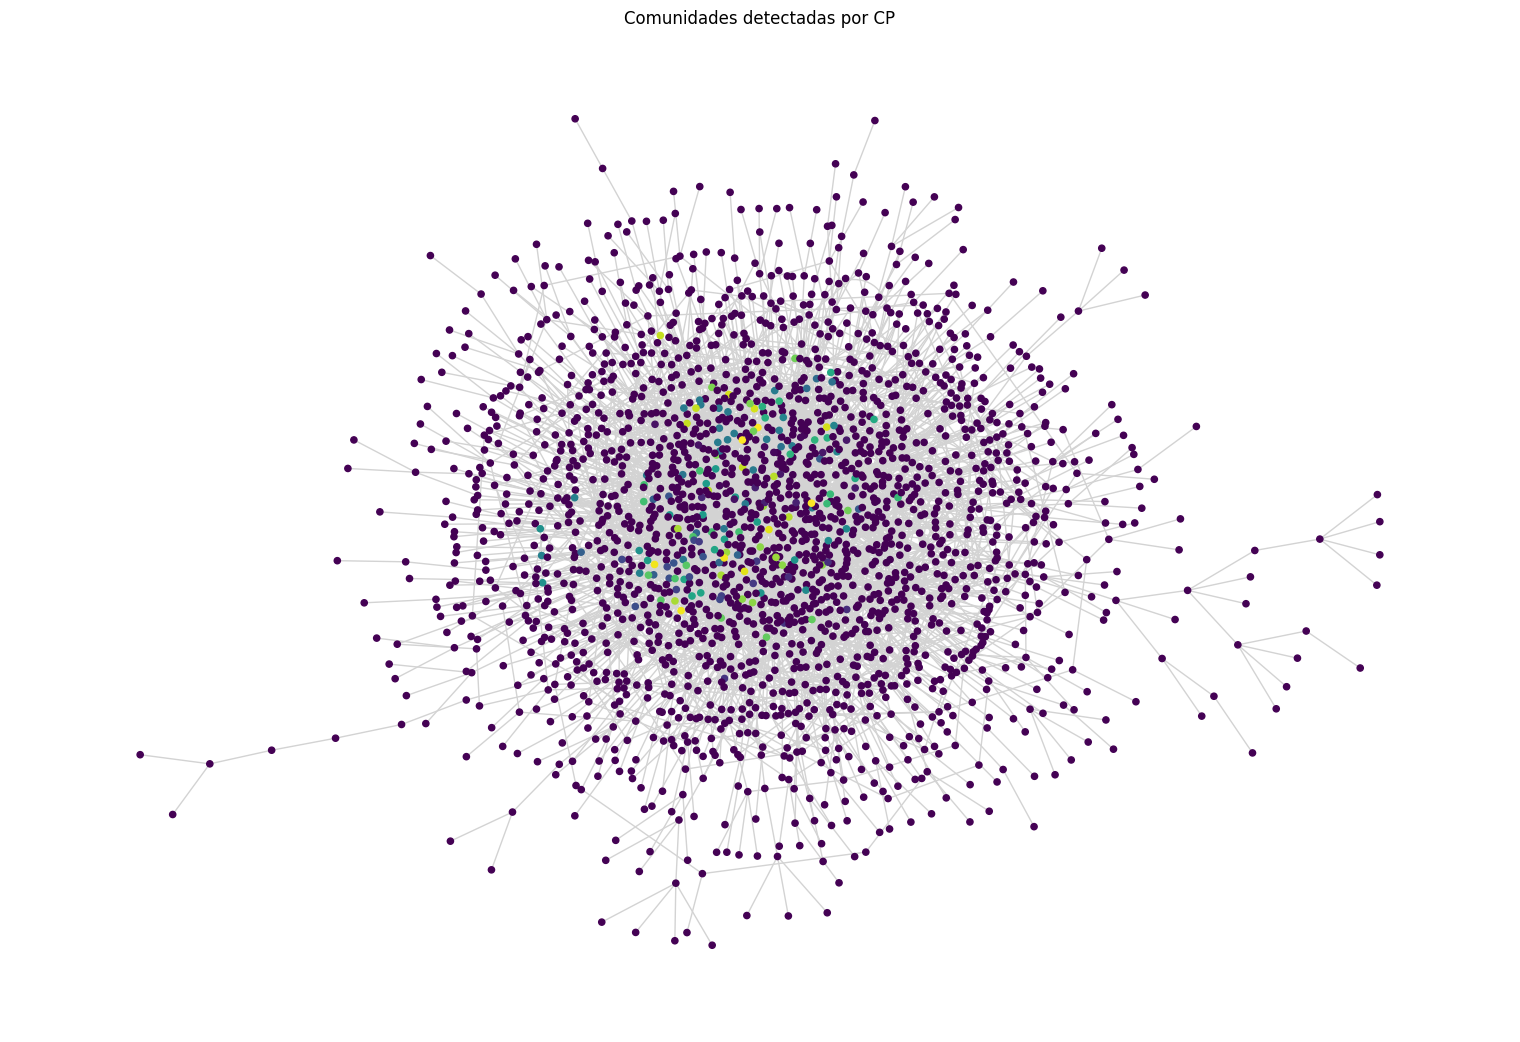

In [151]:
plt.figure(figsize=(15, 10))
pos = nx.kamada_kawai_layout(G=G_undirected)
nx.draw(
    G=G_undirected,
    pos=pos,
    node_size=20,
    node_color=list(cp_fix.values()),
    edge_color='lightgray'
)
plt.title("Comunidades detectadas por CP")
plt.show()

### 2. Analisis de atributos

#### 2.0 Seleccion de variables a analizar

Con el fin de entender las comunidades, primero se realizara una inspeccion general de las variables que se utilizaran para dicho fin. Estas variables son:
- Headquarters Location
- Industries
- Company Type
- Funding Status
- Number of Investments
- Number of Investors
- Total Funding Amount Currency (in USD)
- Number of Funding Rounds

Ademas se dejaran unicamente las empresas que esten activas, es decir `nodos[nodos["Operating Status"] != "Closed"]`.

In [226]:
# Se filtra el dataframe de nodos
nodos_filtered = nodos[nodos["Operating Status"] != "Closed"][[
    'Id',
    'Headquarters Location',
    'Industries',
    'Company Type',
    'Funding Status',
    'Number of Investments',
    'Number of Investors',
    'Total Funding Amount Currency (in USD)', 
    'Number of Funding Rounds',
]].copy()

# Se mapean las comunidades encontradas al dataframe de nodos_filtered
nodos_filtered["Comunidad_Louvain"] = nodos_filtered["Id"].map(partition_louvain)
nodos_filtered["Comunidad_LPA"] = nodos_filtered["Id"].map(lpa_fix)
nodos_filtered["Comunidad_CP"] = nodos_filtered["Id"].map(cp_fix)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)  



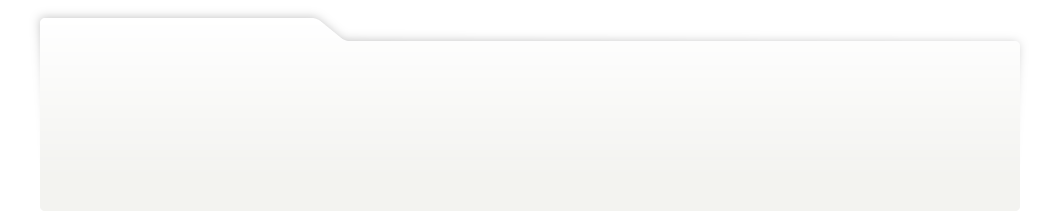
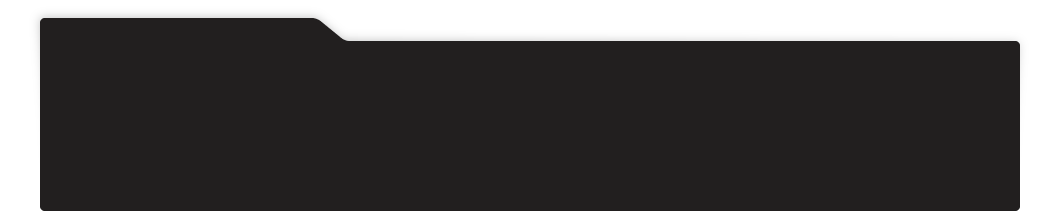
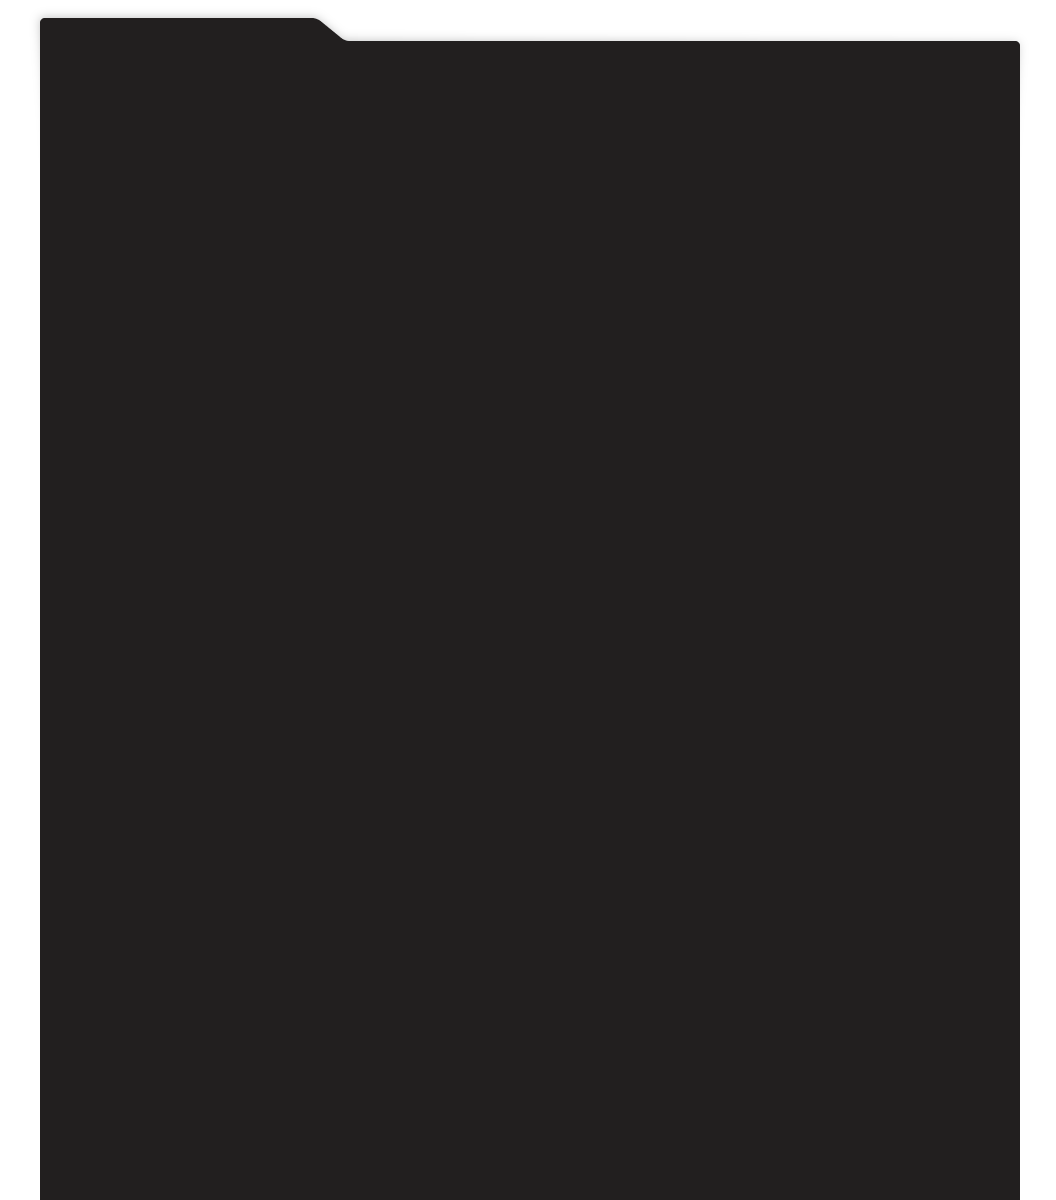
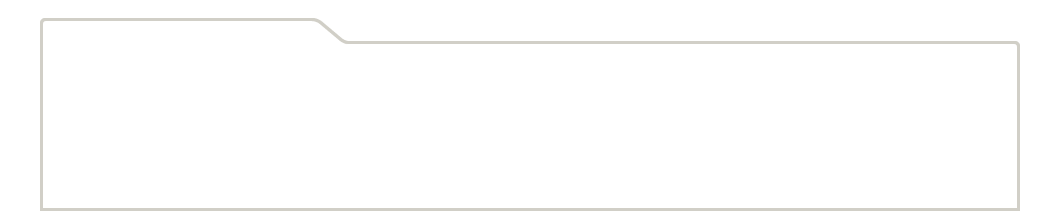
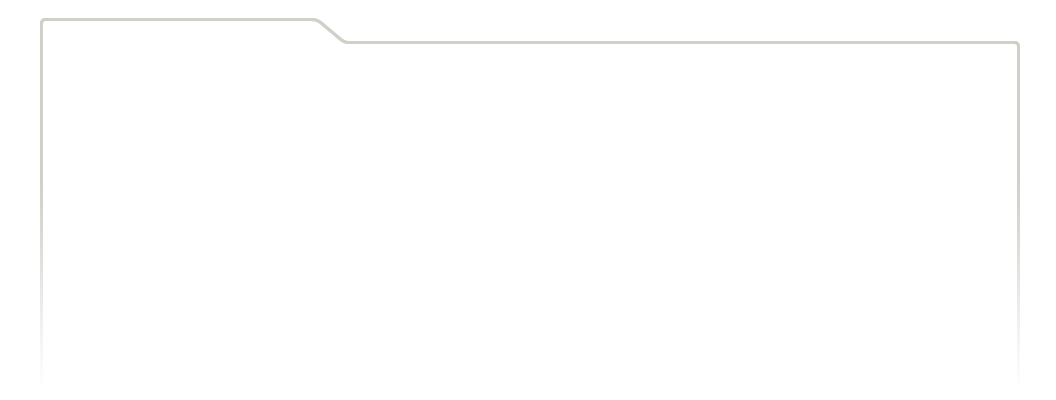
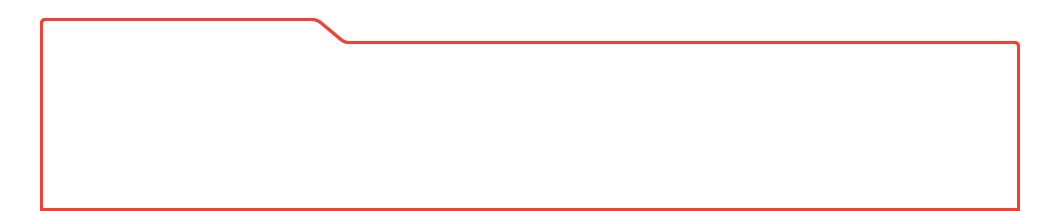
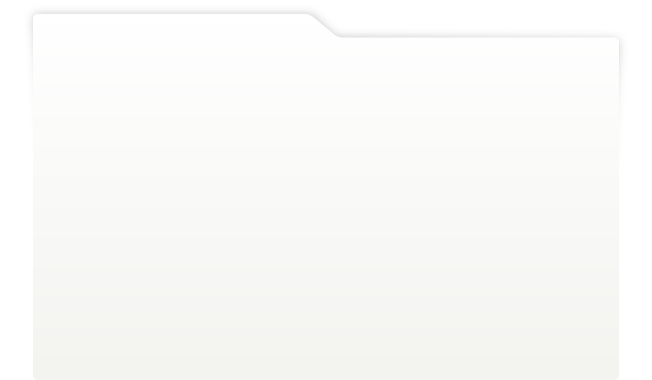
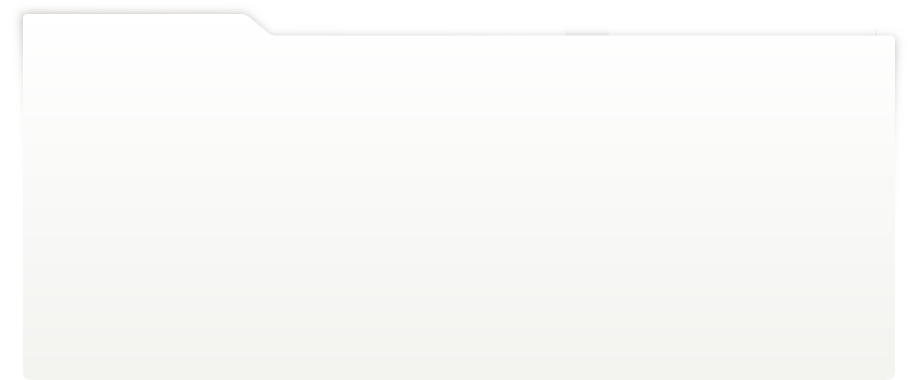
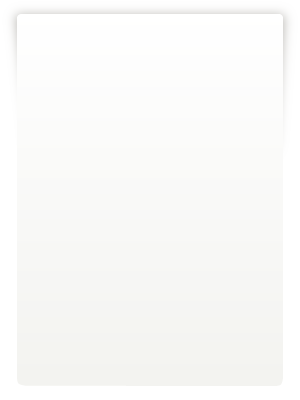
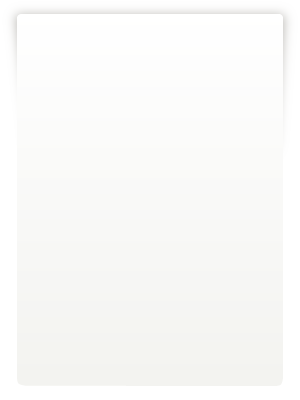
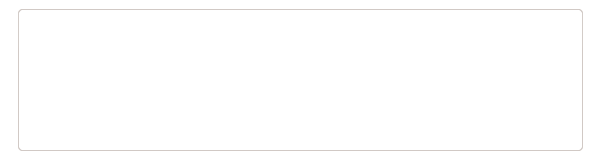
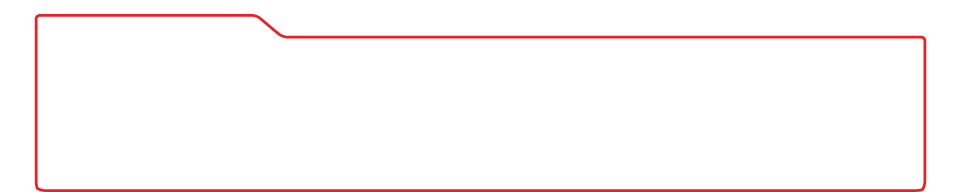
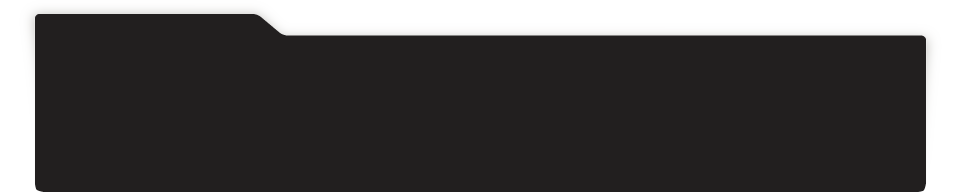
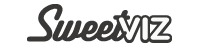
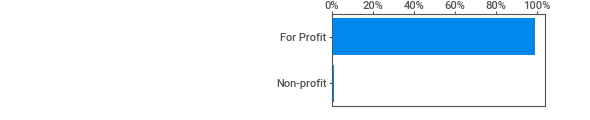
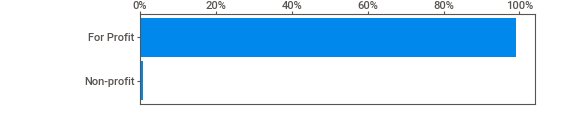
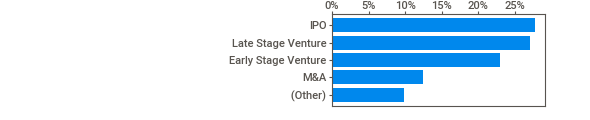
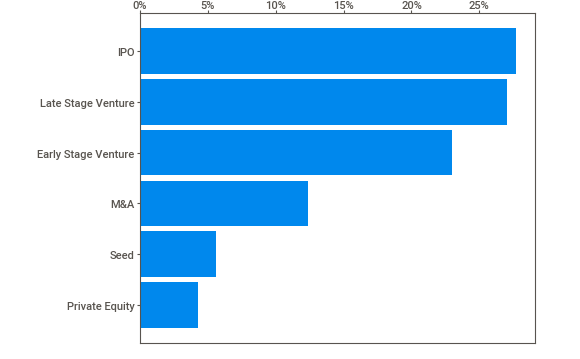
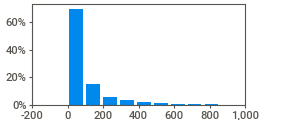
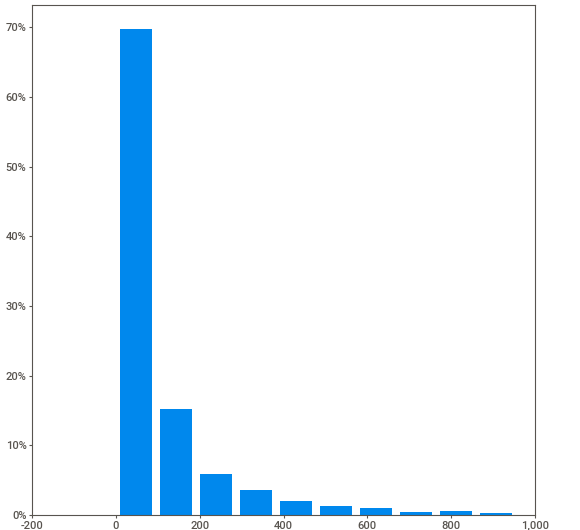
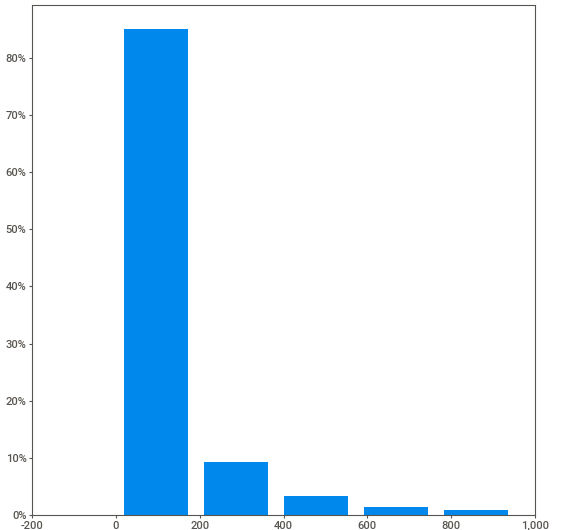
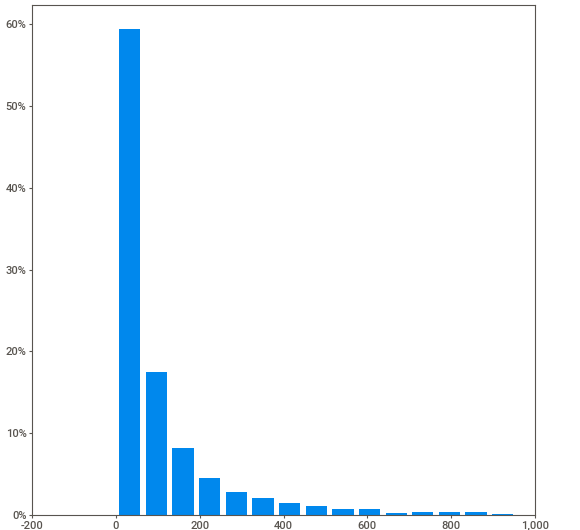
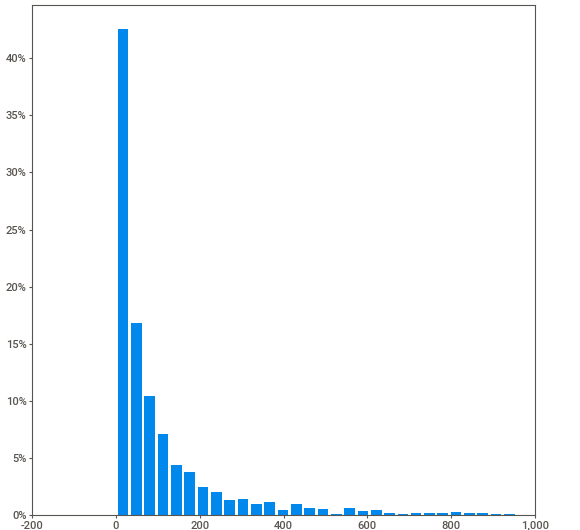
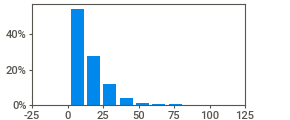
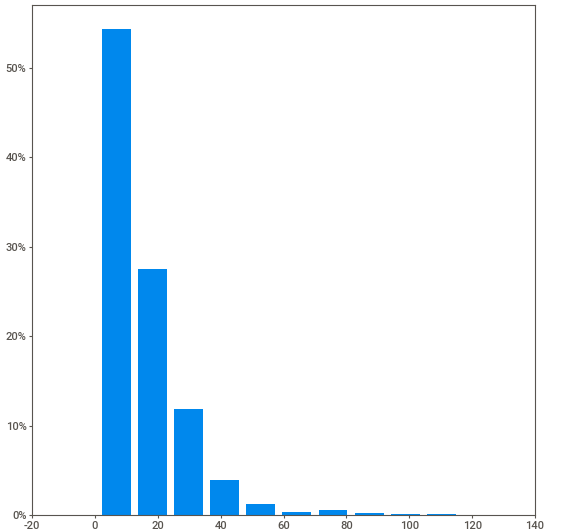
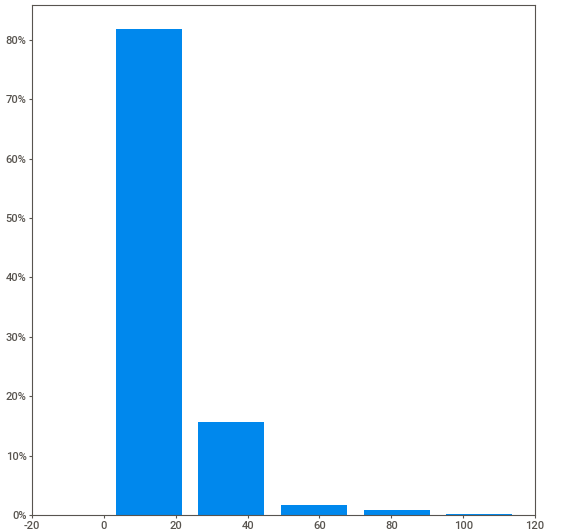
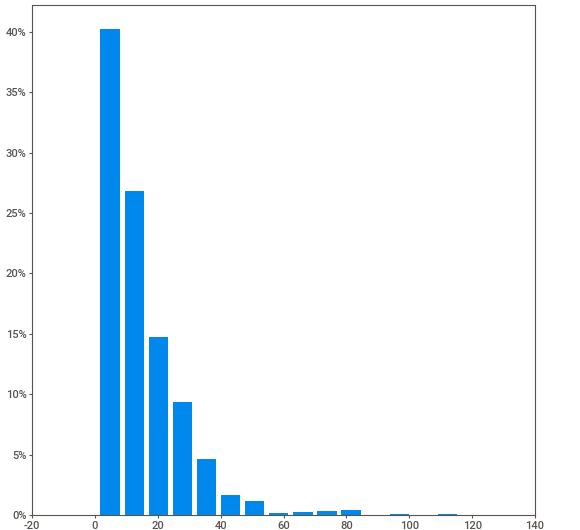
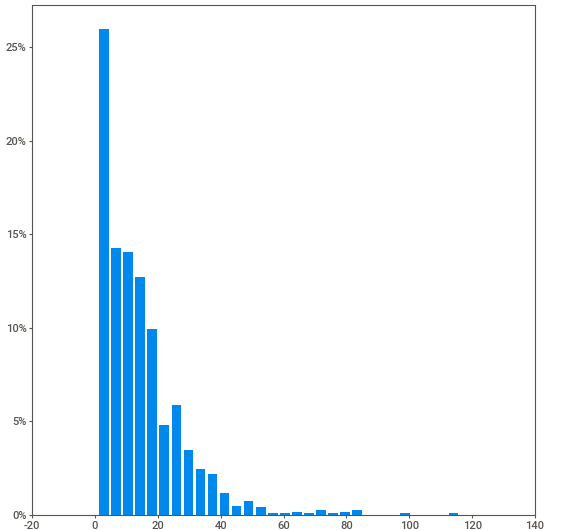
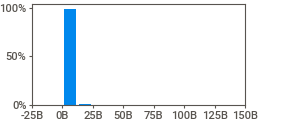
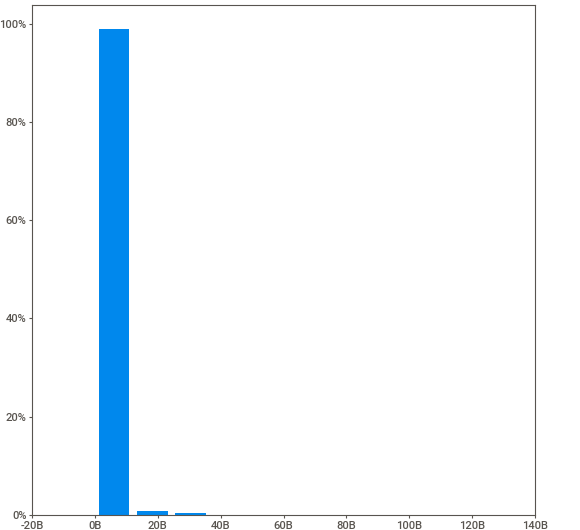
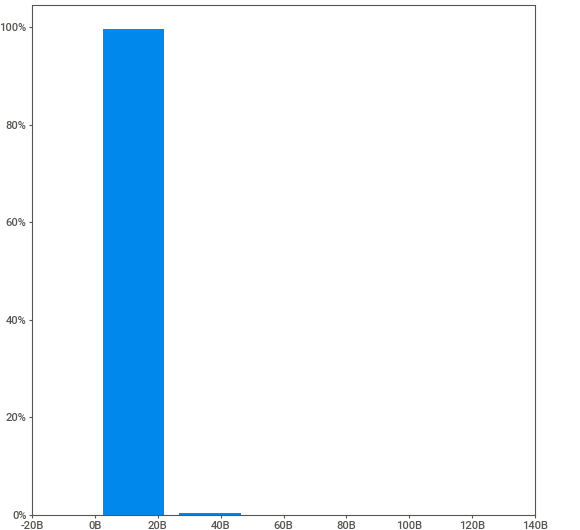
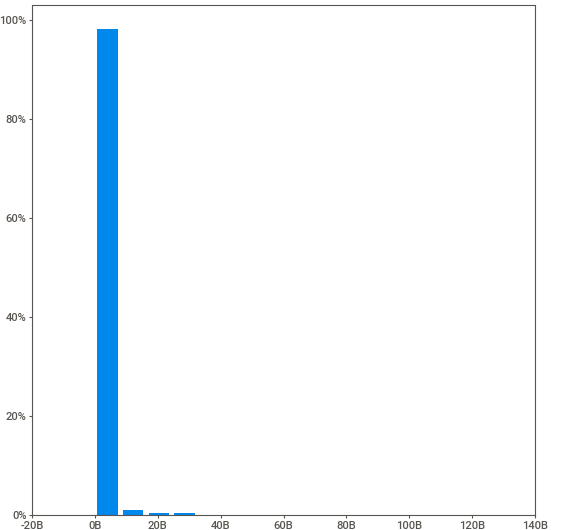
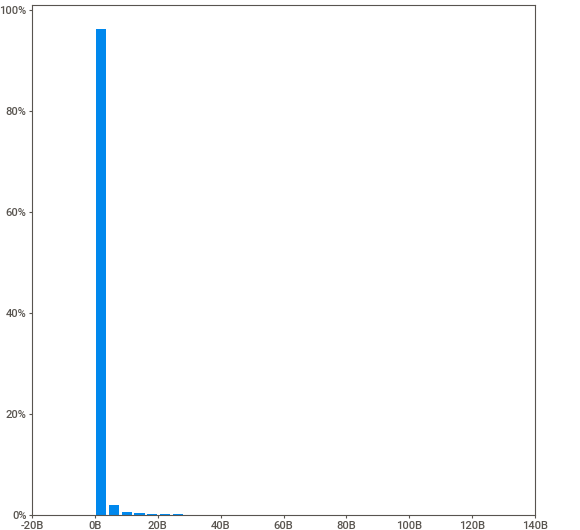
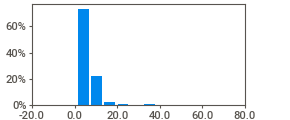
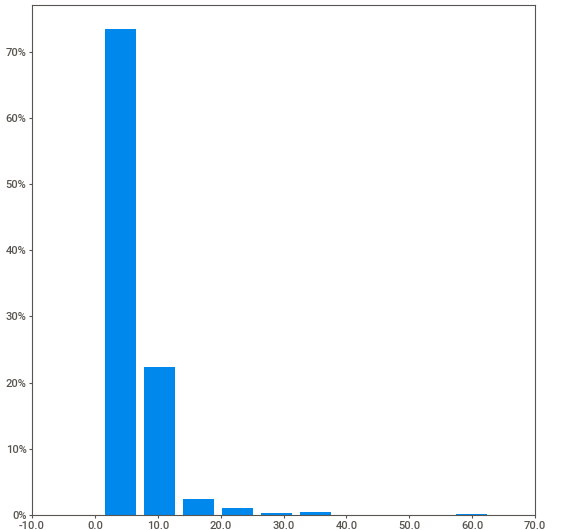
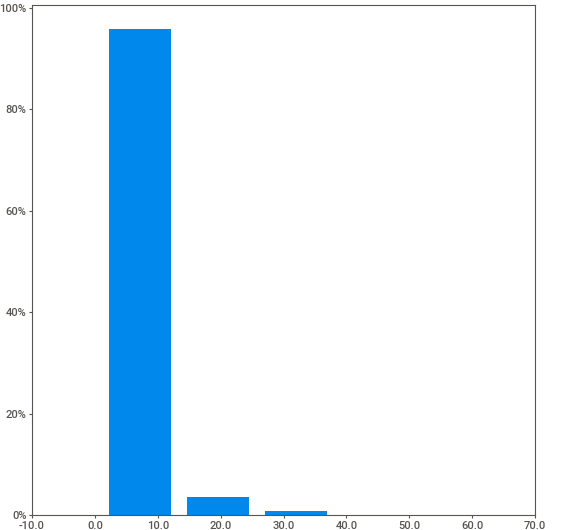
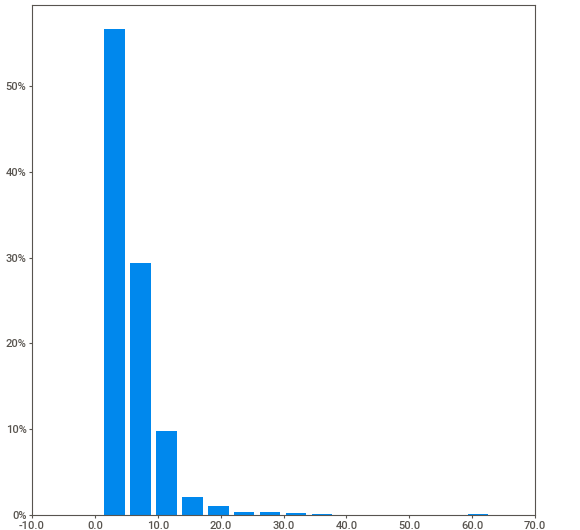
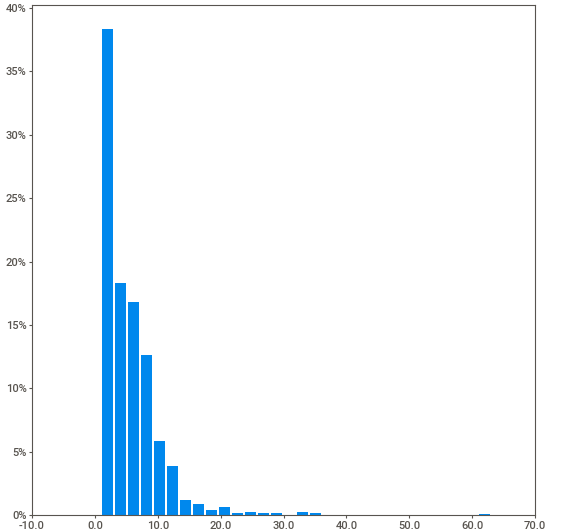
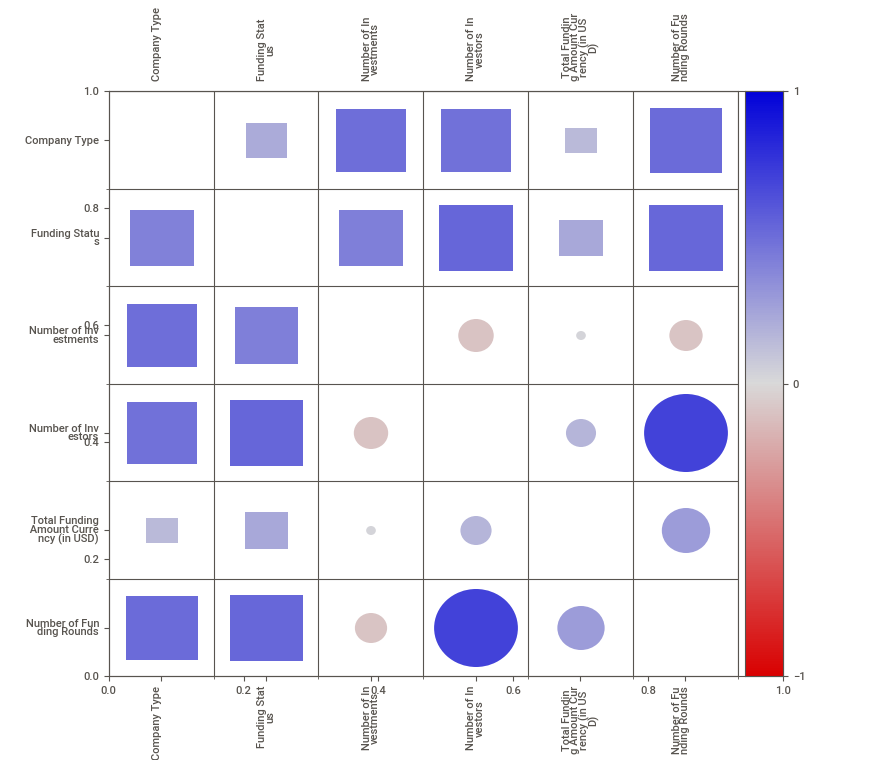
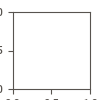

In [227]:
# Se realiza un analisis rapido de las variables seleccionadas
report = sv.analyze(nodos_filtered.drop([c for c in nodos_filtered.columns if c.startswith("Comunidad")], axis=1))
report.show_notebook()

#### 2.1 Comunidades Louvain

In [234]:
louvain_groups = nodos_filtered \
    .groupby(['Comunidad_Louvain']).agg({
        'Id': 'count', 
        'Headquarters Location': lambda x: x.mode(),
        'Industries': lambda x: x.mode(),
        'Company Type': lambda x: x.mode(),
        'Funding Status': lambda x: x.mode(),
        'Number of Investments': 'median',
        'Number of Investors': 'median',
        'Total Funding Amount Currency (in USD)': 'median',
        'Number of Funding Rounds': 'median', 
    }).reset_index() \
    .rename(columns={
        'Id': 'Cantidad de Nodos',
        'Headquarters Location': 'Ubicacion (Moda)',
        'Industries': 'Industrias (Moda)',
        'Company Type': 'Tipo de Compania (Moda)',
        'Funding Status': 'Estado Financiamiento (Moda)',
        'Number of Investments': '#Inversiones (Mediana)',
        'Number of Investors': '#Inversores (Mediana)',
        'Total Funding Amount Currency (in USD)': 'Financiamiento Total (USD) (Mediana)',
        'Number of Funding Rounds': '#Rondas de Financiamiento (Mediana)',
    }).astype({'Comunidad_Louvain': int, "#Inversiones (Mediana)": int, "#Inversores (Mediana)": int, "#Rondas de Financiamiento (Mediana)": int}) \
    .sort_values(by="Cantidad de Nodos", ascending=False)
louvain_groups

Comunidad_Louvain  Cantidad de Nodos  \
2                   2                202   
4                   4                190   
9                   9                188   
7                   7                169   
11                 11                150   
17                 17                110   
20                 20                100   
27                 27                 98   
14                 14                 90   
10                 10                 69   
33                 33                 66   
31                 31                 64   
3                   3                 63   
19                 19                 62   
15                 15                 53   
5                   5                 52   
23                 23                 51   
34                 34                 48   
12                 12                 46   
28                 28                 42   
16                 16                 39   
1                   1                 35   
6                   6                 31   
26                 26                 30   
22                 22                 26   
29                 29                 22   
18                 18                 16   
25                 25                  5   
0                   0                  4   
13                 13                  4   
30                 30                  3   
21                 21                  3   
8                   8                  2   
24                 24                  2   
32                 32                  2   

                                     Ubicacion (Moda)  \
2            San Francisco, California, United States   
4            San Francisco, California, United States   
9            San Francisco, California, United States   
7            San Francisco, California, United States   
11                            Beijing, Beijing, China   
17           San Francisco, California, United States   
20           San Francisco, California, United States   
27                  New York, New York, United States   
14                    London, England, United Kingdom   
10           San Francisco, California, United States   
33                  New York, New York, United States   
31           San Francisco, California, United States   
3                            Toronto, Ontario, Canada   
19           San Francisco, California, United States   
15                    London, England, United Kingdom   
5                          Mumbai, Maharashtra, India   
23                  New York, New York, United States   
34  [London, England, United Kingdom, San Francisc...   
12                    London, England, United Kingdom   
28                  New York, New York, United States   
16                  New York, New York, United States   
1                   New York, New York, United States   
6                   New York, New York, United States   
26                  New York, New York, United States   
22                       Paris, Ile-de-France, France   
29           San Francisco, California, United States   
18  [New York, New York, United States, San Franci...   
25                    Portland, Oregon, United States   
0                  Sydney, New South Wales, Australia   
13  [London, England, United Kingdom, New York, Ne...   
30                            Berlin, Berlin, Germany   
21  [Chapel Hill, North Carolina, United States, S...   
8   [Mumbai, Maharashtra, India, San Francisco, Ca...   
24  [New York, New York, United States, Plano, Tex...   
32  [London, England, United Kingdom, Vilnius, Vil...   

                                    Industrias (Moda) Tipo de Compania (Moda)  \
2        Finance, Financial Services, Venture Capital              For Profit   
4        Finance, Financial Services, Venture Capital              For Profit   
9        Finance, Financial Services, Venture Capital              For Profit   
7        Finance, Financial Services, Vent

Las comunidades de Louvain identificadas en la red revelan patrones significativos respecto a la ubicación, industria, tipo de compañía, estado de financiamiento, inversión y financiamiento total. La mayoría de las organizaciones están concentradas en San Francisco, California, Estados Unidos, lo que sugiere una fuerte presencia de empresas enfocadas en finanzas, servicios financieros y capital de riesgo en esta área geográfica. Además, todas las comunidades se caracterizan por ser compañías con fines de lucro. Los estados de financiamiento varían desde Venture Temprana hasta IPO (Initial Public Offer), con una notable cantidad de empresas en etapas tardías de inversión o que ya han salido a bolsa. Esto indica un ecosistema de organizaciones en diferentes etapas de crecimiento, pero con una inclinación hacia la madurez y estabilidad financiera. Las medianas de inversión y financiamiento total muestran que, mientras algunas comunidades están en etapas iniciales con menor financiamiento y rondas de inversión, otras han acumulado cantidades significativas de capital, lo que refleja una diversidad en la capacidad de atracción de inversión dentro de la red. Este análisis sugiere que para una organización buscando financiamiento, es crucial enfocarse en entidades dentro de las industrias de finanzas y servicios financieros, preferiblemente en San Francisco o áreas con concentraciones similares de organizaciones, y considerar el estado de financiamiento y la etapa de inversión como indicadores claves para la colaboración o el engagement.

#### 2.2 Comunidades LPA

Para las comunidades encontradas con LPA:
- Excluiremos la comunidad 1, ya que contiene alrededor del 60% de los nodos.
- Ademas dado el gran numero de comunidades (266) se analizaran las 5 comunidades con mayor cantidad de nodos y las 5 comunidades con menor cantidad de nodos.

In [238]:
lpa_groups = nodos_filtered \
    .groupby(['Comunidad_LPA']).agg({
        'Id': 'count', 
        'Headquarters Location': lambda x: x.mode(),
        'Industries': lambda x: x.mode(),
        'Company Type': lambda x: x.mode(),
        'Funding Status': lambda x: x.mode(),
        'Number of Investments': 'median',
        'Number of Investors': 'median',
        'Total Funding Amount Currency (in USD)': 'median',
        'Number of Funding Rounds': 'median', 
    }).reset_index() \
    .rename(columns={
        'Id': 'Cantidad de Nodos',
        'Headquarters Location': 'Ubicacion (Moda)',
        'Industries': 'Industrias (Moda)',
        'Company Type': 'Tipo de Compania (Moda)',
        'Funding Status': 'Estado Financiamiento (Moda)',
        'Number of Investments': '#Inversiones (Mediana)',
        'Number of Investors': '#Inversores (Mediana)',
        'Total Funding Amount Currency (in USD)': 'Financiamiento Total (USD) (Mediana)',
        'Number of Funding Rounds': '#Rondas de Financiamiento (Mediana)',
    }).astype({'Comunidad_LPA': int, "#Inversiones (Mediana)": int, "#Inversores (Mediana)": int, "#Rondas de Financiamiento (Mediana)": int}, errors="ignore") \
    .sort_values(by="Cantidad de Nodos", ascending=False)

In [251]:
lpa_groups[lpa_groups["Comunidad_LPA"] != 1].head(5)

Comunidad_LPA  Cantidad de Nodos  \
34              34                  7   
58              58                  7   
52              52                  6   
193            193                  6   
151            151                  6   

                                      Ubicacion (Moda)  \
34   [MontrÃ©al, Quebec, Canada, San Francisco, Cal...   
58                   New York, New York, United States   
52   [Berlin, Berlin, Germany, London, England, Uni...   
193                            Berlin, Berlin, Germany   
151  [Berlin, Berlin, Germany, Stockholm, Stockholm...   

                                     Industrias (Moda)  \
34   [Bitcoin, Blockchain, Cryptocurrency, Financia...   
58   [Angel Investment, Financial Services, Health ...   
52   [Angel Investment, Finance, Financial Services...   
193  [Advertising, Big Data, FinTech, Health Care, ...   
151  [Angel Investment, Financial Services, Venture...   

    Tipo de Compania (Moda) Estado Financiamiento (Moda)  \
34               For Profit   [Early Stage Venture, IPO]   
58               For Profit                   [IPO, M&A]   
52               For Profit          Early Stage Venture   
193              For Profit                          IPO   
151              For Profit          Early Stage Venture   

     #Inversiones (Mediana)  #Inversores (Mediana)  \
34                       26                   11.0   
58                      111                   12.5   
52                      145                    7.0   
193                      28                    8.0   
151                     112                    7.0   

     Financiamiento Total (USD) (Mediana)  #Rondas de Financiamiento (Mediana)  
34                           4.764931e+08                                  6.5  
58                           3.287066e+09                                  7.5  
52                           2.085022e+07                                  1.0  
193                          6.060747e+07                                  2.5  
151                          1.077762e+08                                  3.0

In [253]:
lpa_groups[lpa_groups["Comunidad_LPA"] != 1].tail(5)

Comunidad_LPA  Cantidad de Nodos  \
261            261                  2   
180            180                  2   
181            181                  2   
182            182                  2   
23              23                  1   

                                      Ubicacion (Moda)  \
261  [Tarrytown, New York, United States, Washingto...   
180  [Cologne, Nordrhein-Westfalen, Germany, Paris,...   
181  [London, England, United Kingdom, Poznan, Wiel...   
182  [Luxembourg, Luxembourg, Luxembourg, Paris, Il...   
23               Minneapolis, Minnesota, United States   

                                     Industrias (Moda)  \
261  [Biopharma, Biotechnology, Pharmaceutical, Gov...   
180  [Finance, Financial Services, Venture Capital,...   
181  [Automotive, Retail, Shopping, Banking, Financ...   
182       Banking, Credit, Finance, Financial Services   
23   Biotechnology, Health Care, Health Diagnostics...   

    Tipo de Compania (Moda) Estado Financiamiento (Moda)  \
261              For Profit                          IPO   
180              For Profit                          M&A   
181              For Profit                          M&A   
182              For Profit                          IPO   
23               For Profit                          IPO   

     #Inversiones (Mediana)  #Inversores (Mediana)  \
261                      26                    1.0   
180                     111                    1.0   
181                      47                    1.0   
182                      96                    1.0   
23                       74                    3.0   

     Financiamiento Total (USD) (Mediana)  #Rondas de Financiamiento (Mediana)  
261                             8900000.0                                  1.0  
180                                   NaN                                  1.0  
181                            24935498.0                                  1.0  
182                           774445082.0                                  1.0  
23                            367044995.0                                  5.0

El análisis de las comunidades encontradas mediante el algoritmo LPA revela una diversidad notable tanto en ubicaciones geográficas como en sectores de industria, con un enfoque predominante en compañías con fines de lucro. Las cinco comunidades más grandes destacan por su variedad en ubicaciones, abarcando desde Montréal y San Francisco hasta Berlín y Londres, reflejando una presencia global. Estas comunidades se caracterizan por una concentración en sectores relacionados con FinTech, servicios financieros, salud, y tecnología blockchain, indicando una tendencia hacia industrias innovadoras y de rápido crecimiento. Los estados de financiamiento varían desde empresas en etapas tempranas de inversión hasta aquellas que han alcanzado la IPO o M&A, mostrando un amplio espectro en el desarrollo empresarial. La financiación total y el número de rondas de financiamiento sugieren que algunas de estas comunidades han logrado atraer inversiones significativas, con medias que destacan tanto en el número de inversiones como en el financiamiento total obtenido. Por otro lado, las cinco comunidades más pequeñas también reflejan una diversidad geográfica y sectorial, pero con una inclinación hacia la biotecnología, servicios financieros, y el sector de salud, lo cual podría indicar nichos de interés específico para inversores o colaboradores buscando innovación en estos campos. Este análisis subraya la importancia de considerar tanto la ubicación geográfica como el sector de industria al buscar colaboraciones o financiamiento, y destaca la variabilidad en el desarrollo y necesidades de financiamiento entre diferentes comunidades en la red.

#### 2.3 Comunidades - CP

Para las comunidades encontradas con CP:
- Excluiremos la comunidad -1, ya que representa los nodos que no fueron asignados a una comunidad.

In [254]:
cp_groups = nodos_filtered \
    .groupby(['Comunidad_CP']).agg({
        'Id': 'count', 
        'Headquarters Location': lambda x: x.mode(),
        'Industries': lambda x: x.mode(),
        'Company Type': lambda x: x.mode(),
        'Funding Status': lambda x: x.mode(),
        'Number of Investments': 'median',
        'Number of Investors': 'median',
        'Total Funding Amount Currency (in USD)': 'median',
        'Number of Funding Rounds': 'median', 
    }).reset_index() \
    .rename(columns={
        'Id': 'Cantidad de Nodos',
        'Headquarters Location': 'Ubicacion (Moda)',
        'Industries': 'Industrias (Moda)',
        'Company Type': 'Tipo de Compania (Moda)',
        'Funding Status': 'Estado Financiamiento (Moda)',
        'Number of Investments': '#Inversiones (Mediana)',
        'Number of Investors': '#Inversores (Mediana)',
        'Total Funding Amount Currency (in USD)': 'Financiamiento Total (USD) (Mediana)',
        'Number of Funding Rounds': '#Rondas de Financiamiento (Mediana)',
    }).astype({'Comunidad_CP': int, "#Inversiones (Mediana)": int, "#Inversores (Mediana)": int, "#Rondas de Financiamiento (Mediana)": int}, errors="ignore") \
    .sort_values(by="Cantidad de Nodos", ascending=False)
cp_groups[cp_groups["Comunidad_CP"] != -1]

Comunidad_CP  Cantidad de Nodos  \
19            18                 17   
1              0                  5   
32            31                  5   
38            37                  5   
10             9                  5   
3              2                  4   
25            24                  4   
27            26                  4   
42            41                  4   
8              7                  3   
14            13                  3   
2              1                  3   
6              5                  3   
4              3                  3   
43            42                  3   
39            38                  3   
30            29                  3   
34            33                  3   
36            35                  3   
12            11                  3   
21            20                  3   
15            14                  3   
26            25                  3   
28            27                  3   
24            23                  3   
23            22                  3   
29            28                  3   
22            21                  3   
20            19                  3   
18            17                  3   
46            45                  3   
45            44                  3   
40            39                  3   
41            40                  3   
37            36                  3   
35            34                  3   
31            30                  3   
9              8                  2   
33            32                  2   
13            12                  2   
7              6                  2   
11            10                  2   
44            43                  2   
16            15                  2   
5              4                  1   
17            16                  1   

                                     Ubicacion (Moda)  \
19  [New York, New York, United States, San Franci...   
1            San Francisco, California, United States   
32           San Francisco, California, United States   
38                            Gurgaon, Haryana, India   
10                            Beijing, Beijing, China   
3            San Francisco, California, United States   
25  [Dulles, Virginia, United States, Menlo Park, ...   
27  [Gurgaon, Haryana, India, London, England, Uni...   
42  [Menlo Park, California, United States, Montev...   
8   [Gurgaon, Haryana, India, Redmond, Washington,...   
14                            Beijing, Beijing, China   
2   [New York, New York, United States, San Franci...   
6   [London, England, United Kingdom, New York, Ne...   
4   [London, England, United Kingdom, Oakland, Cal...   
43                  New York, New York, United States   
39  [Bangalore, Karnataka, India, New York, New Yo...   
30  [Boston, Massachusetts, United States, Boulder...   
34  [Beijing, Beijing, China, San Francisco, Calif...   
36                    Basel, Basel-Stadt, Switzerland   
12  [San Francisco, California, United States, She...   
21  [Austin, Texas, United States, Greenwich, Conn...   
15  [Buenos Aires, Distrito Federal, Argentina, Ne...   
26  [Gurgaon, Haryana, India, New Delhi, Delhi, In...   
28  [Mountain View, California, United States, Pal...   
24                        Bengaluru, Karnataka, India   
23                 Dubai, Dubai, United Arab Emirates   
29  [Menlo Park, California, United States, Miami,...   
22  [New York, New York, United States, Ottawa, On...   
20  [Bethesda, Maryland, United States, Rochester,...   
18                  New York, New York, United States   
46  [Menlo Park, California, United States, San Fr...   
45  [Abu Dhabi, Abu Dhabi, United Arab Emirates, M...   
40  [Beijing, Beijing, China, Changyang, Beijing, ...   
41                  New York, New York, United States   
37           San Francisco, California, United States   
35                            Berlin, Berlin, Germany   
31  [Chicago, Illinois, United States, Mountain Vi...   
9   

Las comunidades encontradas mediante el método de Cliques Percolation en la red social presentan una amplia diversidad en términos de ubicación, industria, tipo de compañía y estado de financiamiento. La comunidad más grande está marcada por una presencia significativa tanto en Nueva York como en San Francisco, Estados Unidos, indicando una fuerte concentración de organizaciones en estas áreas geográficas. Estas comunidades están mayoritariamente compuestas por empresas con fines de lucro, enfocadas en una variedad de industrias que van desde blockchain y criptomonedas hasta servicios financieros y tecnología de la información, con una notable presencia de startups en el sector de videojuegos y aplicaciones móviles. El estado de financiamiento varía ampliamente, incluyendo desde empresas en etapa temprana hasta aquellas que han alcanzado la IPO, lo que refleja la diversidad en la madurez de las organizaciones dentro de estas comunidades. La financiación total y el número de rondas de financiamiento muestran una variación considerable, lo que sugiere que dentro de estas comunidades existen tanto startups en fases iniciales de desarrollo como empresas establecidas con historiales significativos de financiación. Este análisis destaca la importancia de considerar la ubicación geográfica y el sector de industria al buscar colaboraciones o financiamiento dentro de la red, ya que estas características pueden influir en la compatibilidad y los objetivos compartidos entre organizaciones.

### 3. Conclusiones y recomendaciones

- De acuerdo a los diferentes metodos de deteccion de comunidades utilizado encontramos que cada algoritmo detecta un numero de comunidades diferentes como lo es el label propagation,  metodo que mayor numero de comunidades detecta.
Y teniendo en cuenta "la busqueda"  de inversion este metodo es pertinente dado que se cuenta con gran diversidad de inversores incluso en otros continentes, y teniendo en cuenta que financian las nuevas tecnologìas, altos volumenes y rondas de inversiones.

- De otra parte el metodo Louvan detecta tan solo 35 comunidades, forma grupos homogeneos por ubicación (principalmente USA), Industrias y tipo de compañia(Servicios financieros y servicios tecnologìcos)dado lo anterior, podemos acceder a esas entidades financieras que les interese el proyecto para invertir.

- Es importante identificar  las   comunidades que mas cantidad de dinero invierten,para encontrar ese grupo de inversores.

- Tambien identificar por comunidades el volumen grande que para nuestro caso es de 20 inversiones, que corresponde a las comunidad 9.

- Se recomienda también hacer pruebas con los algoritmos Girvan-Newman, ya que nos permite ver las conexiones mas fuertes de la red para detectar comunidades "cerradas" en las cuales no es posible acceder.